In [55]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

import os
import time
import argparse
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import sys
from collections import defaultdict

try:
    import wandb
except Exception as e:
    pass

import wilds
from wilds.common.data_loaders import get_train_loader, get_eval_loader
from wilds.common.grouper import CombinatorialGrouper
from wilds.datasets.unlabeled.wilds_unlabeled_dataset import WILDSPseudolabeledSubset

from utils import set_seed, Logger, BatchLogger, log_config, ParseKwargs, load, initialize_wandb, log_group_data, parse_bool, get_model_prefix, move_to
from train import train, evaluate, infer_predictions
from algorithms.initializer import initialize_algorithm, infer_d_out
from transforms import initialize_transform
from models.initializer import initialize_model
from configs.utils import populate_defaults
import configs.supported as supported

import torch.multiprocessing

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import seaborn as sns

# Required arguments

args = [
    '--dataset', 'fmow',
    '--algorithm', 'ERM',
    '--root_dir', 'data',
    '--progress_bar'
]

parser = argparse.ArgumentParser()

parser.add_argument('-d', '--dataset', choices=wilds.supported_datasets, required=True)
parser.add_argument('--algorithm', required=True, choices=supported.algorithms)
parser.add_argument('--root_dir', required=True,
                  help='The directory where [dataset]/data can be found (or should be downloaded to, if it does not exist).')

# Dataset
parser.add_argument('--split_scheme', help='Identifies how the train/val/test split is constructed. Choices are dataset-specific.')
parser.add_argument('--dataset_kwargs', nargs='*', action=ParseKwargs, default={},
                  help='keyword arguments for dataset initialization passed as key1=value1 key2=value2')
parser.add_argument('--download', default=False, type=parse_bool, const=True, nargs='?',
                  help='If true, tries to download the dataset if it does not exist in root_dir.')
parser.add_argument('--frac', type=float, default=1.0,
                  help='Convenience parameter that scales all dataset splits down to the specified fraction, for development purposes. Note that this also scales the test set down, so the reported numbers are not comparable with the full test set.')
parser.add_argument('--version', default=None, type=str, help='WILDS labeled dataset version number.')

# Unlabeled Dataset
parser.add_argument('--unlabeled_split', default=None, type=str, choices=wilds.unlabeled_splits,  help='Unlabeled split to use. Some datasets only have some splits available.')
parser.add_argument('--unlabeled_version', default=None, type=str, help='WILDS unlabeled dataset version number.')
parser.add_argument('--use_unlabeled_y', default=False, type=parse_bool, const=True, nargs='?', 
                  help='If true, unlabeled loaders will also the true labels for the unlabeled data. This is only available for some datasets. Used for "fully-labeled ERM experiments" in the paper. Correct functionality relies on CrossEntropyLoss using ignore_index=-100.')

# Loaders
parser.add_argument('--loader_kwargs', nargs='*', action=ParseKwargs, default={})
parser.add_argument('--unlabeled_loader_kwargs', nargs='*', action=ParseKwargs, default={})
parser.add_argument('--train_loader', choices=['standard', 'group'])
parser.add_argument('--uniform_over_groups', type=parse_bool, const=True, nargs='?', help='If true, sample examples such that batches are uniform over groups.')
parser.add_argument('--distinct_groups', type=parse_bool, const=True, nargs='?', help='If true, enforce groups sampled per batch are distinct.')
parser.add_argument('--n_groups_per_batch', type=int)
parser.add_argument('--unlabeled_n_groups_per_batch', type=int)
parser.add_argument('--batch_size', type=int)
parser.add_argument('--unlabeled_batch_size', type=int)
parser.add_argument('--eval_loader', choices=['standard'], default='standard')
parser.add_argument('--gradient_accumulation_steps', type=int, default=1, help='Number of batches to process before stepping optimizer and schedulers. If > 1, we simulate having a larger effective batch size (though batchnorm behaves differently).')

# Model
parser.add_argument('--model', choices=supported.models)
parser.add_argument('--model_kwargs', nargs='*', action=ParseKwargs, default={},
                  help='keyword arguments for model initialization passed as key1=value1 key2=value2')
parser.add_argument('--noisystudent_add_dropout', type=parse_bool, const=True, nargs='?', help='If true, adds a dropout layer to the student model of NoisyStudent.')
parser.add_argument('--noisystudent_dropout_rate', type=float)
parser.add_argument('--pretrained_model_path', default=None, type=str, help='Specify a path to pretrained model weights')
parser.add_argument('--load_featurizer_only', default=False, type=parse_bool, const=True, nargs='?', help='If true, only loads the featurizer weights and not the classifier weights.')

# NoisyStudent-specific loading
parser.add_argument('--teacher_model_path', type=str, help='Path to NoisyStudent teacher model weights. If this is defined, pseudolabels will first be computed for unlabeled data before anything else runs.')

# Transforms
parser.add_argument('--transform', choices=supported.transforms)
parser.add_argument('--additional_train_transform', choices=supported.additional_transforms, help='Optional data augmentations to layer on top of the default transforms.')
parser.add_argument('--target_resolution', nargs='+', type=int, help='The input resolution that images will be resized to before being passed into the model. For example, use --target_resolution 224 224 for a standard ResNet.')
parser.add_argument('--resize_scale', type=float)
parser.add_argument('--max_token_length', type=int)
parser.add_argument('--randaugment_n', type=int, help='Number of RandAugment transformations to apply.')

# Objective
parser.add_argument('--loss_function', choices=supported.losses)
parser.add_argument('--loss_kwargs', nargs='*', action=ParseKwargs, default={},
                  help='keyword arguments for loss initialization passed as key1=value1 key2=value2')

# Algorithm
parser.add_argument('--groupby_fields', nargs='+')
parser.add_argument('--group_dro_step_size', type=float)
parser.add_argument('--coral_penalty_weight', type=float)
parser.add_argument('--dann_penalty_weight', type=float)
parser.add_argument('--dann_classifier_lr', type=float)
parser.add_argument('--dann_featurizer_lr', type=float)
parser.add_argument('--dann_discriminator_lr', type=float)
parser.add_argument('--afn_penalty_weight', type=float)
parser.add_argument('--safn_delta_r', type=float)
parser.add_argument('--hafn_r', type=float)
parser.add_argument('--use_hafn', default=False, type=parse_bool, const=True, nargs='?')
parser.add_argument('--irm_lambda', type=float)
parser.add_argument('--irm_penalty_anneal_iters', type=int)
parser.add_argument('--self_training_lambda', type=float)
parser.add_argument('--self_training_threshold', type=float)
parser.add_argument('--pseudolabel_T2', type=float, help='Percentage of total iterations at which to end linear scheduling and hold lambda at the max value')
parser.add_argument('--soft_pseudolabels', default=False, type=parse_bool, const=True, nargs='?')
parser.add_argument('--algo_log_metric')
parser.add_argument('--process_pseudolabels_function', choices=supported.process_pseudolabels_functions)

# Model selection
parser.add_argument('--val_metric')
parser.add_argument('--val_metric_decreasing', type=parse_bool, const=True, nargs='?')

# Optimization
parser.add_argument('--n_epochs', type=int)
parser.add_argument('--optimizer', choices=supported.optimizers)
parser.add_argument('--lr', type=float)
parser.add_argument('--weight_decay', type=float)
parser.add_argument('--max_grad_norm', type=float)
parser.add_argument('--optimizer_kwargs', nargs='*', action=ParseKwargs, default={},
                  help='keyword arguments for optimizer initialization passed as key1=value1 key2=value2')

# Scheduler
parser.add_argument('--scheduler', choices=supported.schedulers)
parser.add_argument('--scheduler_kwargs', nargs='*', action=ParseKwargs, default={},
                  help='keyword arguments for scheduler initialization passed as key1=value1 key2=value2')
parser.add_argument('--scheduler_metric_split', choices=['train', 'val'], default='val')
parser.add_argument('--scheduler_metric_name')

# Evaluation
parser.add_argument('--process_outputs_function', choices = supported.process_outputs_functions)
parser.add_argument('--evaluate_all_splits', type=parse_bool, const=True, nargs='?', default=True)
parser.add_argument('--eval_splits', nargs='+', default=[])
parser.add_argument('--eval_only', type=parse_bool, const=True, nargs='?', default=False)
parser.add_argument('--eval_epoch', default=None, type=int, help='If eval_only is set, then eval_epoch allows you to specify evaluating at a particular epoch. By default, it evaluates the best epoch by validation performance.')

# Misc
parser.add_argument('--device', type=int, nargs='+', default=[0])
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--log_dir', default='./logs')
parser.add_argument('--log_every', default=50, type=int)
parser.add_argument('--save_step', type=int)
parser.add_argument('--save_best', type=parse_bool, const=True, nargs='?', default=True)
parser.add_argument('--save_last', type=parse_bool, const=True, nargs='?', default=True)
parser.add_argument('--save_pred', type=parse_bool, const=True, nargs='?', default=True)
parser.add_argument('--no_group_logging', type=parse_bool, const=True, nargs='?')
parser.add_argument('--progress_bar', type=parse_bool, const=True, nargs='?', default=False)
parser.add_argument('--resume', type=parse_bool, const=True, nargs='?', default=False, help='Whether to resume from the most recent saved model in the current log_dir.')

# Weights & Biases
parser.add_argument('--use_wandb', type=parse_bool, const=True, nargs='?', default=False)
parser.add_argument('--wandb_api_key_path', type=str,
                  help="Path to Weights & Biases API Key. If use_wandb is set to True and this argument is not specified, user will be prompted to authenticate.")
parser.add_argument('--wandb_kwargs', nargs='*', action=ParseKwargs, default={},
                  help='keyword arguments for wandb.init() passed as key1=value1 key2=value2')

config = parser.parse_args(args)
config = populate_defaults(config)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


{'airport': 0, 'airport_hangar': 1, 'airport_terminal': 2, 'amusement_park': 3, 'aquaculture': 4, 'archaeological_site': 5, 'barn': 6, 'border_checkpoint': 7, 'burial_site': 8, 'car_dealership': 9, 'construction_site': 10, 'crop_field': 11, 'dam': 12, 'debris_or_rubble': 13, 'educational_institution': 14, 'electric_substation': 15, 'factory_or_powerplant': 16, 'fire_station': 17, 'flooded_road': 18, 'fountain': 19, 'gas_station': 20, 'golf_course': 21, 'ground_transportation_station': 22, 'helipad': 23, 'hospital': 24, 'impoverished_settlement': 25, 'interchange': 26, 'lake_or_pond': 27, 'lighthouse': 28, 'military_facility': 29, 'multi-unit_residential': 30, 'nuclear_powerplant': 31, 'office_building': 32, 'oil_or_gas_facility': 33, 'park': 34, 'parking_lot_or_garage': 35, 'place_of_worship': 36, 'police_station': 37, 'port': 38, 'prison': 39, 'race_track': 40, 'railway_bridge': 41, 'recreational_facility': 42, 'road_bridge': 43, 'runway': 44, 'shipyard': 45, 'shopping_mall': 46, 'sin

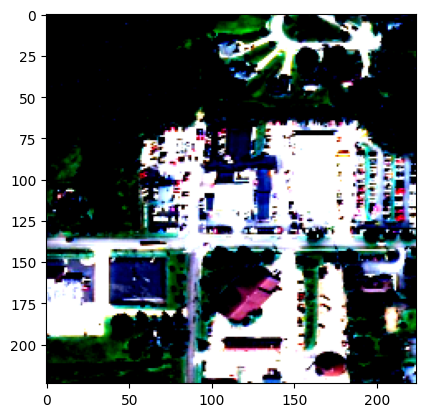

In [72]:
root_dir = '../data'

full_dataset = wilds.get_dataset(
        dataset=config.dataset,
        version=config.version,
        root_dir=root_dir,
        download=config.download,
        split_scheme=config.split_scheme,
        **config.dataset_kwargs)

category_to_index = full_dataset.category_to_idx
index_to_category = {v: k for k, v in category_to_index.items()}
print(category_to_index)
print(index_to_category)
train_transform = initialize_transform(
    transform_name=config.transform,
    config=config,
    dataset=full_dataset,
    additional_transform_name=config.additional_train_transform,
    is_training=True)

# eval_transform = initialize_transform(
#     transform_name=config.transform,
#     config=config,
#     dataset=full_dataset,
#     is_training=False)

# train_data = full_dataset.get_subset(
#     "train",
#     transform=train_transform,
# )

# actual = numpy.random.binomial(1,.9,size = 1000)
# predicted = numpy.random.binomial(1,.9,size = 1000)
def print_matrix(save_y_pred, save_y_true):
        print('accuracy_score', metrics.accuracy_score(save_y_pred, save_y_true))

        cm = metrics.confusion_matrix(save_y_true, save_y_pred)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        total_instances_per_class = np.sum(cm, axis=1)
        correct_predictions = np.diag(cm)

        # Find the class with the maximum number of misclassifications
        misclassifications = total_instances_per_class - correct_predictions
        top_misclassified_classes = np.argsort(misclassifications)[::-1][:5]
        top_misclassified_counts = misclassifications[top_misclassified_classes]
        
        
        class_accuracy_percentage = (correct_predictions / total_instances_per_class) * 100
        class_accuracy_dict = {}
        for class_label, accuracy in enumerate(class_accuracy_percentage):
                class_accuracy_dict[class_label] = accuracy

        # Print the top 5 misclassified classes and their counts
        print("Top 5 misclassified classes (count):")
        for i, class_label in enumerate(top_misclassified_classes, start=1):
                print(f"{i}. Class {class_label} ({index_to_category[class_label]}): {top_misclassified_counts[i-1]} misclassifications. Accuracy: {class_accuracy_dict[class_label]:.2f}")
        
        
        top_correct_classes = np.argsort(correct_predictions)[::-1][:5]
        top_correct_counts = correct_predictions[top_correct_classes]
        
        print("\nTop 5 correctly classified classes (count):")
        for i, class_label in enumerate(top_correct_classes, start=1):
                print(f"{i}. Class {class_label} ({index_to_category[class_label]}): {top_correct_counts[i-1]} correct predictions. Accuracy: {class_accuracy_dict[class_label]:.2f}")
        

        # Sort the class labels based on accuracy percentage
        sorted_class_labels = sorted(class_accuracy_dict, key=class_accuracy_dict.get, reverse=True)

        # Get the top 5 and bottom 5 classes based on accuracy percentage
        top_5_classes = sorted_class_labels[:5]
        bottom_5_classes = sorted_class_labels[-5:]

        # Print the top 5 and bottom 5 classes along with their accuracy percentages
        print("\nTop 5 classes based on accuracy percentage:")
        for class_label in top_5_classes:
                print(f"Class {class_label} ({index_to_category[class_label]}): Accuracy = {class_accuracy_dict[class_label]:.2f}%. Count = {total_instances_per_class[class_label]}")

        print("\nBottom 5 classes based on accuracy percentage:")
        for class_label in bottom_5_classes:
                print(f"Class {class_label} ({index_to_category[class_label]}): Accuracy = {class_accuracy_dict[class_label]:.2f}%. Count = {total_instances_per_class[class_label]}")

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_normalized, annot=False, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        plt.show()


train_data = full_dataset.get_subset( "train",
transform=train_transform
)

train_loader = get_train_loader("standard", train_data, batch_size=16)


for labeled_batch in train_loader:
    x, y, metadata = labeled_batch

    plt.imshow(x[1].permute(1, 2, 0))
    print('y', y[0])
    print(metadata[0])
    region, year, label, from_source_domain = metadata[0]
    # # year group 0 is 2002  
    print('region', region)
    print('year', year)
    print('label', label)
    print('from_source_domain', from_source_domain)

    #z = grouper.metadata_to_group(metadata)
    #print('Group', z[0])
    break


accuracy_score 0.5144291659127918
Top 5 misclassified classes (count):
1. Class 47 (single-unit_residential): 785 misclassifications. Accuracy: 19.98
2. Class 36 (place_of_worship): 742 misclassifications. Accuracy: 37.75
3. Class 14 (educational_institution): 563 misclassifications. Accuracy: 34.00
4. Class 29 (military_facility): 465 misclassifications. Accuracy: 50.37
5. Class 30 (multi-unit_residential): 415 misclassifications. Accuracy: 19.73

Top 5 correctly classified classes (count):
1. Class 42 (recreational_facility): 1239 correct predictions. Accuracy: 76.34
2. Class 11 (crop_field): 905 correct predictions. Accuracy: 79.60
3. Class 29 (military_facility): 472 correct predictions. Accuracy: 50.37
4. Class 36 (place_of_worship): 450 correct predictions. Accuracy: 37.75
5. Class 60 (wind_farm): 351 correct predictions. Accuracy: 87.97

Top 5 classes based on accuracy percentage:
Class 60 (wind_farm): Accuracy = 87.97%. Count = 399
Class 55 (toll_booth): Accuracy = 87.22%. Coun

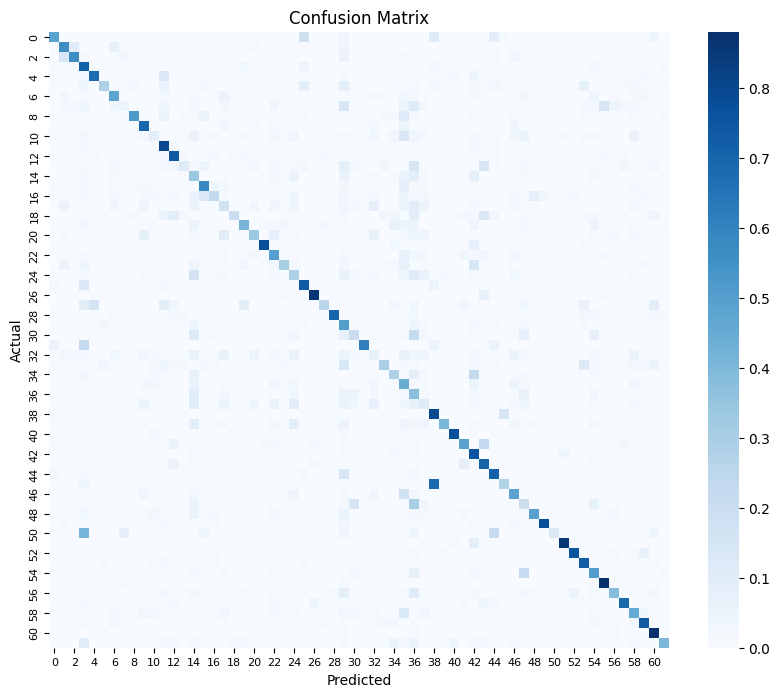

In [67]:
save_y_true_cnn = np.load('save_y_true_cnn.npy')
save_y_pred_cnn = np.load('save_y_pred_cnn.npy')
print_matrix(save_y_pred_cnn, save_y_true_cnn)

accuracy_score 0.49176768590555453
Top 5 misclassified classes (count):
1. Class 47 (single-unit_residential): 829 misclassifications. Accuracy: 15.49
2. Class 29 (military_facility): 598 misclassifications. Accuracy: 36.18
3. Class 36 (place_of_worship): 584 misclassifications. Accuracy: 51.01
4. Class 14 (educational_institution): 517 misclassifications. Accuracy: 39.39
5. Class 42 (recreational_facility): 500 misclassifications. Accuracy: 69.19

Top 5 correctly classified classes (count):
1. Class 42 (recreational_facility): 1123 correct predictions. Accuracy: 69.19
2. Class 11 (crop_field): 909 correct predictions. Accuracy: 79.95
3. Class 36 (place_of_worship): 608 correct predictions. Accuracy: 51.01
4. Class 29 (military_facility): 339 correct predictions. Accuracy: 36.18
5. Class 22 (ground_transportation_station): 336 correct predictions. Accuracy: 48.55

Top 5 classes based on accuracy percentage:
Class 26 (interchange): Accuracy = 82.27%. Count = 220
Class 55 (toll_booth): A

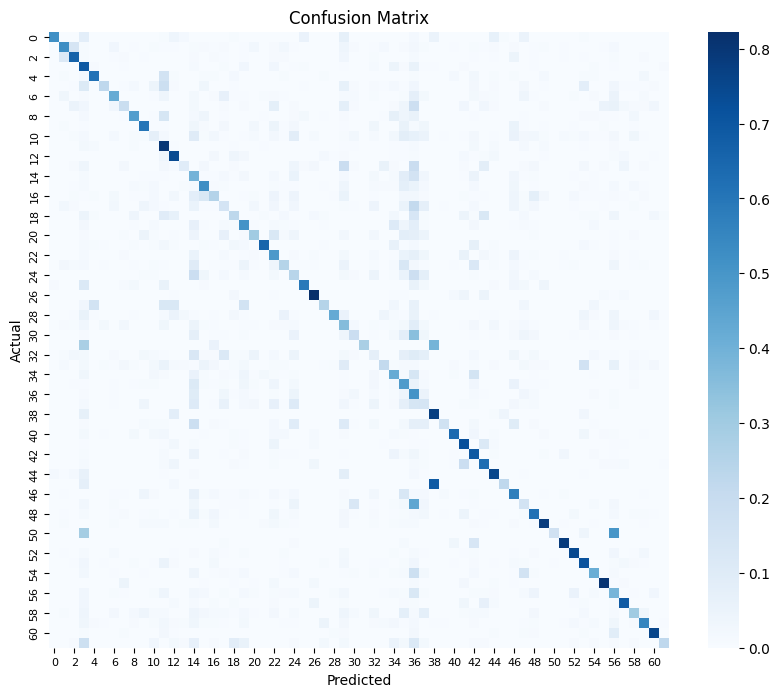

In [68]:
save_y_true_vit = np.load('save_y_true_vit.npy')
save_y_pred_vit = np.load('save_y_pred_vit.npy')
print_matrix(save_y_pred_vit, save_y_true_vit)

In [62]:
print(np.array_equal(save_y_true_vit, save_y_true_cnn))

True


FileNotFoundError: [Errno 2] No such file or directory: 'predictions.txt'